# **Write Your Abstracts Carefully - The Impact of Abstract Reporting Quality on Findability by Semi-Automated Title-Abstract Screening Tools**
### **Generation of results**

#### **Part I: Data**

In Part I, the datasets are imported. These are the datasets from the previously conducted systematic reviews by Andaur Navarro *et al.* (2022) and Heus *et al.* (2018), respectively. For each review, the titles and abstracts of the records along with the title-abstract level inclusions, full-text level inclusions, and abstract characteristics are present in the dataset. The abstract characterstics consist of: (I) abstract reporting quality as defined by TRIPOD scores, (II) abstract structural components, and (III) abstract language usage.

#### **Part II: Ranking** 

A screening tool (ASReview) was used to simulate the title-abstract screening by using active learning to rank and prioritize records that are most likely to be relevant for the review. These ranking algorithms use a feature extractor and classifier to compute rankings. The simulations were continued until all records have passed, and the final rankings were saved and are here merged with the datasets.

#### **Part III: Evaluation**

In the evaluation, the association between abstract characteristics (as described under *Data*) and the ranking position (as computed with the tool under *Ranking*) is examined.

------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from pathlib import Path
from scipy.stats import spearmanr, mannwhitneyu

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### **Part I: Data**
Load the data that were preprocessed with the data_preprocessing.ipynb notebook:

In [4]:
path_data = "../data/processed/"

In [5]:
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.csv'):
        file_path = os.path.join(path_data, file_name)
        df = pd.read_csv(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

In [6]:
for key, df in review_dic.items():
    df.rename(columns={'Unnamed: 0': 'record_id'}, inplace=True)

#### **Part II: Ranking**

Load rankings of previous study

In [9]:
path_output = "../output/rankings/"

In [10]:
train_models = ['logistic'] 
feature_models = ['tfidf', 'sbert', 'doc2vec']
query_models = ['max']
n_simulations = 200 

In [11]:
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model + "_" + feature_model + "_" + query_model )
                sim_list_names.append(review_id)
             
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_output +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_output + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

Merge the rankings with the datasets

In [13]:
warnings.filterwarnings('ignore', category=FutureWarning)

review_dic_merged = review_dic.copy()

for i in review_dic:
    for j in range(0, len(multiple_sims)):
        if multiple_sims[j][0].split('_')[0] == i:

            for k in multiple_sims[j][3]:          

                review_sim = multiple_sims[j][0] + "_" + str(j)
                review_key = multiple_sims[j][0].split('_')[0]
                index_list = multiple_sims[j][3][k][0]['record_id']
                review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_list)})
            
    review_dic_merged[review_key]['ranking_average_logistic_tfidf'] = review_dic_merged[review_key].filter(like='logistic_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_sbert'] = review_dic_merged[review_key].filter(like='logistic_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_doc2vec'] = review_dic_merged[review_key].filter(like='logistic_doc2vec').mean(axis=1)

#### **Part III: Evaluation**

Convert the data into a presentable table

In [16]:
characteristics = ['1i', '1ii', '1iii', '1iv',
                   '2i', '2ii', '2iii', '2iv', '2v',
                   '2vi', '2vii', '2viii', '2ix', '2x',
                   '2xi', '2xii',
                   'percentage_reported',
                   'word_count', 'avg_sentence_length', 'structured',
                   'tfidf_deviation'
                  ]
review = ['Prog1', 'Prog3'
         ]
rankings = ['ranking_average_logistic_tfidf', 
            'ranking_average_logistic_sbert',
            'ranking_average_logistic_doc2vec'
           ]

In [17]:
results = []

for review_name in review:
    df = review_dic_merged[review_name]  
    

    for characteristic in characteristics:
        
        unique_values = df[characteristic].dropna().unique()
        is_binary = set(unique_values) == {0, 1}  

        for ranking in rankings:

            df_clean = df[[characteristic, ranking]].dropna()
            
            if characteristic == 'tfidf_deviation':
                df_clean['standardized_tfidf_deviation'] = (df_clean[characteristic] - df_clean[characteristic].mean()) / df_clean[characteristic].std()
            
            if len(df_clean) > 1:  
                result_dict = {
                    'Review': review_name,
                    'Characteristic': characteristic,
                    'Ranking method': ranking,
                    'Correlation type': 'Binary' if is_binary else 'Continuous',
                    'Correlation coefficient': None,
                    'p-value': None,
                    'Beta': None,
                    'R-squared': None,
                    'Event rate/Mean (sd)': None
                }
                
                if is_binary:
                    
                    event_rate = df_clean[characteristic].mean()

                    group1 = df_clean[df_clean[characteristic] == 0][ranking]
                    group2 = df_clean[df_clean[characteristic] == 1][ranking]
                    
                    if len(group1) > 0 and len(group2) > 0:
                        U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                        n1, n2 = len(group1), len(group2)
                        rank_biserial_corr = 1 - (2 * U / (n1 * n2))  

                        result_dict['Correlation coefficient'] = rank_biserial_corr
                        result_dict['p-value'] = p_value
                    
                    result_dict['Event rate/Mean (sd)'] = f"{event_rate:.2f}"
                
                else:
    
                    mean_val = df_clean[characteristic].mean()
                    std_val = df_clean[characteristic].std()

                    if characteristic == 'tfidf_deviation':
                        X = sm.add_constant(df_clean['standardized_tfidf_deviation'])  
                    else:
                        X = sm.add_constant(df_clean[characteristic])
                    
                    model = sm.OLS(df_clean[ranking], X).fit()
                    
                    result_dict['Correlation coefficient'] = spearmanr(df_clean[characteristic], df_clean[ranking])[0]
                    result_dict['p-value'] = spearmanr(df_clean[characteristic], df_clean[ranking])[1]
                    result_dict['Beta'] = model.params[1] 
                    result_dict['R-squared'] = model.rsquared

                    result_dict['Event rate/Mean (sd)'] = f"{mean_val:.2f} ({std_val:.2f})"
                
                results.append(result_dict)

correlation_df = pd.DataFrame(results)
correlation_df = correlation_df.applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)

correlation_df

,Review,Characteristic,Ranking method,Correlation type,Correlation coefficient,p-value,Beta,R-squared,Event rate/Mean (sd)
0,Prog1,1i,ranking_average_logistic_tfidf,Binary,-0.096,0.520,NaN,NaN,0.11
1,Prog1,1i,ranking_average_logistic_sbert,Binary,-0.114,0.447,NaN,NaN,0.11
2,Prog1,1i,ranking_average_logistic_doc2vec,Binary,-0.127,0.397,NaN,NaN,0.11
3,Prog1,1ii,ranking_average_logistic_tfidf,Binary,-0.434,0.000,NaN,NaN,0.66
4,Prog1,1ii,ranking_average_logistic_sbert,Binary,-0.492,0.000,NaN,NaN,0.66
...,...,...,...,...,...,...,...,...,...
121,Prog3,structured,ranking_average_logistic_sbert,Binary,-0.212,0.000,NaN,NaN,0.58
122,Prog3,structured,ranking_average_logistic_doc2vec,Binary,-0.230,0.000,NaN,NaN,0.58
123,Prog3,tfidf_deviation,ranking_average_logistic_tfidf,Continuous,0.009,0.913,13.314,0.001,0.00 (0.00)
124,Prog3,tfidf_deviation,ranking_average_logistic_sbert,Continuous,0.002,0.978,9.506,0.000,0.00 (0.00)


Clean the dataframe for publication

In [19]:
correlation_df['Review'] = correlation_df['Review'].replace({'Prog1': 'Review 1', 
                                                             'Prog3': 'Review 2'})
correlation_df['Characteristic'] = correlation_df['Characteristic'].replace({'percentage_reported': 'Percentage of TRIPOD criteria reported', 
                                                                             'word_count': 'Number of words in abstract',
                                                                             'avg_sentence_length':'Average number of words per sentence',
                                                                             'structured': 'Structured vs unstructured abstracts',
                                                                             'tfidf_deviation': 'Abstract terminology usage (TF-IDF deviation)'})

correlation_df['Ranking method'] = correlation_df['Ranking method'].replace({'ranking_average_logistic_tfidf': 'TF-IDF', 
                                                                             'ranking_average_logistic_sbert': 'sBERT',
                                                                             'ranking_average_logistic_doc2vec': 'Doc2Vec'})
correlation_df_final = correlation_df.drop(columns=['Beta'])

correlation_df_final.to_excel('../output/results/coefs_table.xlsx', index=False)  

correlation_df_final

,Review,Characteristic,Ranking method,Correlation type,Correlation coefficient,p-value,R-squared,Event rate/Mean (sd)
0,Review 1,1i,TF-IDF,Binary,-0.096,0.520,NaN,0.11
1,Review 1,1i,sBERT,Binary,-0.114,0.447,NaN,0.11
2,Review 1,1i,Doc2Vec,Binary,-0.127,0.397,NaN,0.11
3,Review 1,1ii,TF-IDF,Binary,-0.434,0.000,NaN,0.66
4,Review 1,1ii,sBERT,Binary,-0.492,0.000,NaN,0.66
...,...,...,...,...,...,...,...,...
121,Review 2,Structured vs unstructured abstracts,sBERT,Binary,-0.212,0.000,NaN,0.58
122,Review 2,Structured vs unstructured abstracts,Doc2Vec,Binary,-0.230,0.000,NaN,0.58
123,Review 2,Abstract terminology usage (TF-IDF deviation),TF-IDF,Continuous,0.009,0.913,0.001,0.00 (0.00)
124,Review 2,Abstract terminology usage (TF-IDF deviation),sBERT,Continuous,0.002,0.978,0.000,0.00 (0.00)


Create figures for in the results that represent the associations between abstract characteristics and ranking positions

In [21]:
rename_map = {'Prog1': 'Review 1', 'Prog3': 'Review 2'}
review_dic_merged = {rename_map.get(k, k): v for k, v in review_dic_merged.items()}

for key, value in review_dic_merged.items():
    review_dic_merged[key] = review_dic_merged[key].rename(columns={'ranking_average_logistic_tfidf': 'TF-IDF', 
                                                                    'ranking_average_logistic_sbert': 'sBERT',
                                                                    'ranking_average_logistic_doc2vec': 'Doc2Vec'})

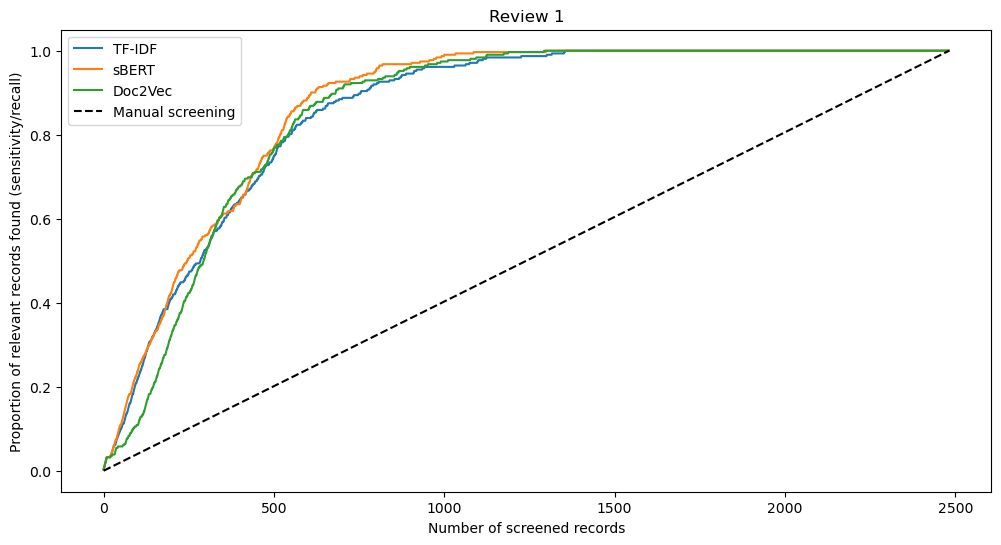

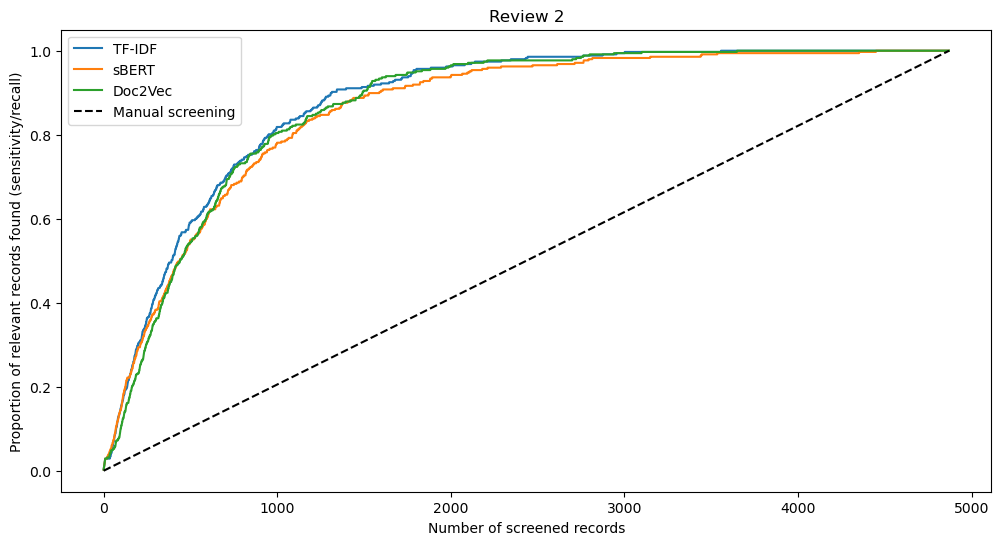

In [22]:
rankings = ['TF-IDF', 'sBERT', 'Doc2Vec']
dfs = ['Review 1', 'Review 2']

for df_name in dfs:
    plt.figure(figsize=(12, 6))  
    df = review_dic_merged[df_name]
    N = len(df)  

    for ranking in rankings:
        df_sort = df.sort_values(by=ranking, ascending=True)
        labels = df_sort['label_ta_included']
        labels_series = pd.Series(labels)
        total_ones = labels_series.sum()
        cumulative_sum = labels_series.cumsum()
        proportion_ones = cumulative_sum / total_ones
        
        plt.plot(range(N), proportion_ones, label=ranking)

    plt.plot([0, N], [0, 1], 'k--', label='Manual screening')  

    plt.title(df_name)
    plt.xlabel("Number of screened records")
    plt.ylabel("Proportion of relevant records found (sensitivity/recall)")
    plt.legend()
    plt.show()  

**(a) Abstract TRIPOD adherence**

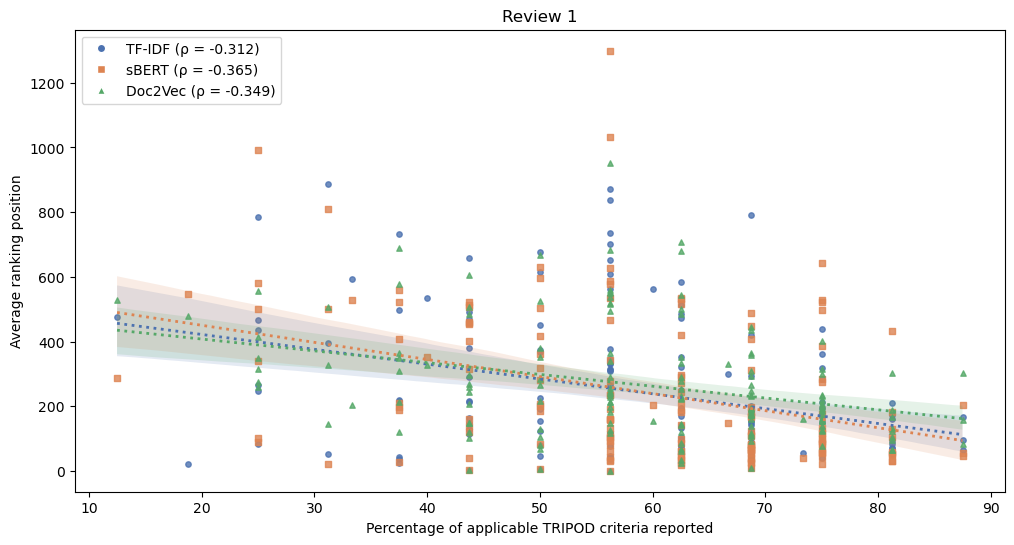

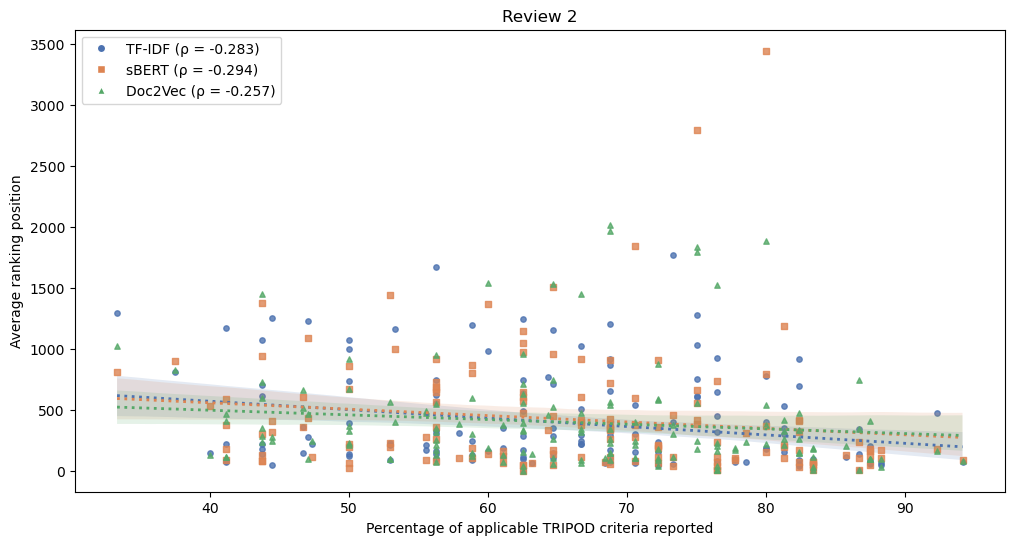

In [24]:
dfs = ['Review 1', 'Review 2'] 

marker_styles = ['o', 's', '^'] 

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    x_variables = ['percentage_reported']
    y_variables = ['TF-IDF', 'sBERT', 'Doc2Vec']
    
    plt.figure(figsize=(12, 6))
    
    colors = sns.color_palette("deep", len(y_variables))
    
    legend_handles = []

    for i, y_var in enumerate(y_variables):
        x = df_plot1['percentage_reported']
        y = df_plot1[y_var]

        df_clean = df_plot1[[x_variables[0], y_var]].dropna()
        spearman_corr, _ = spearmanr(df_clean[x_variables[0]], df_clean[y_var])

        sns.regplot(
            x=x, y=y, scatter=False,  
            line_kws={"linewidth": 2, "linestyle": "dotted", "color": colors[i]}
        )  

        scatter = plt.scatter(x, y, color=colors[i], marker=marker_styles[i], s=15, alpha=0.8)  

        legend_handles.append(plt.Line2D(
            [0], [0], marker=marker_styles[i], color='w',
            markerfacecolor=colors[i], markersize=6, 
            label=f"{y_var} (ρ = {spearman_corr:.3f})"
        ))

    plt.ylabel("Average ranking position")
    plt.xlabel("Percentage of applicable TRIPOD criteria reported")

    plt.legend(handles=legend_handles, loc='upper left', frameon=True)

    plt.title(f'{df_name}')
    plt.show()

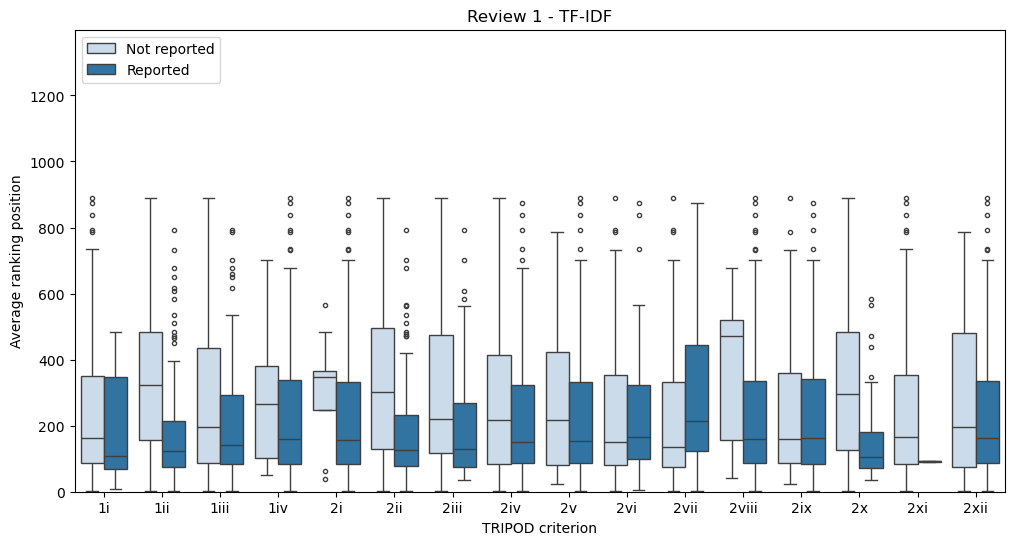

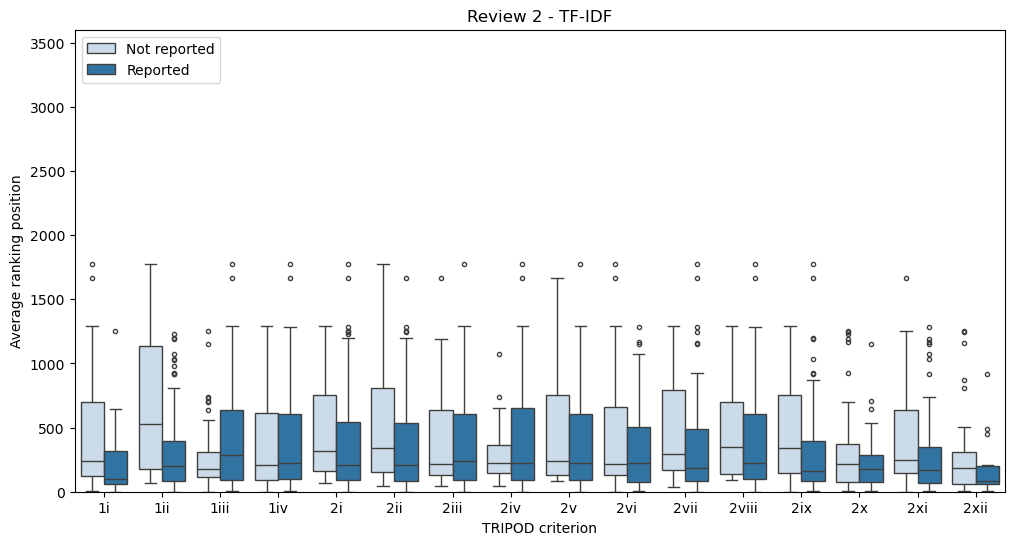

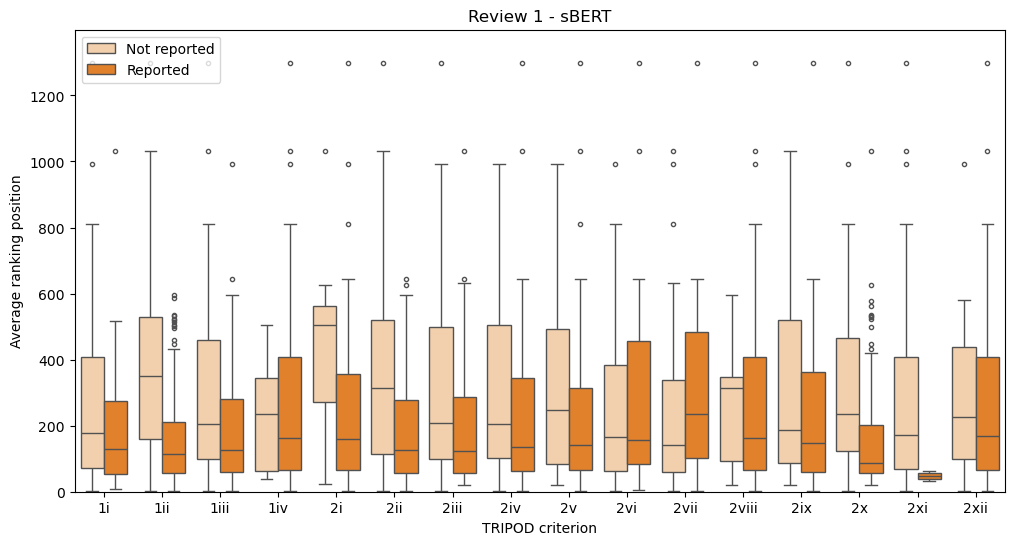

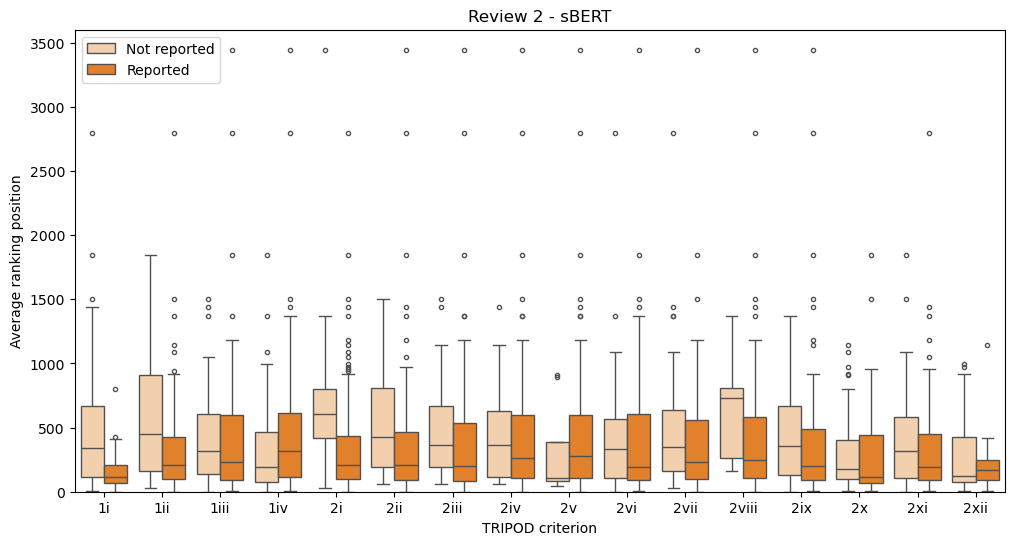

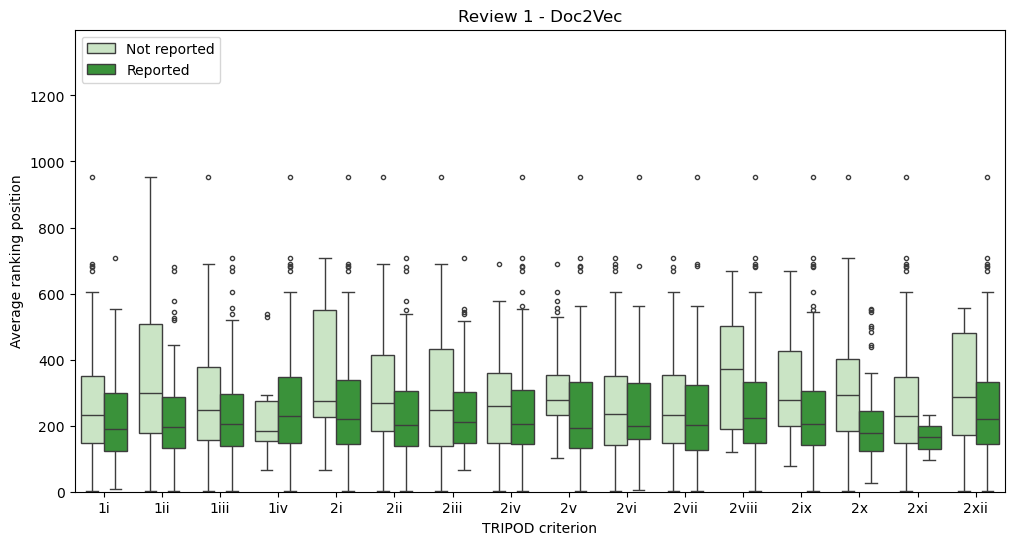

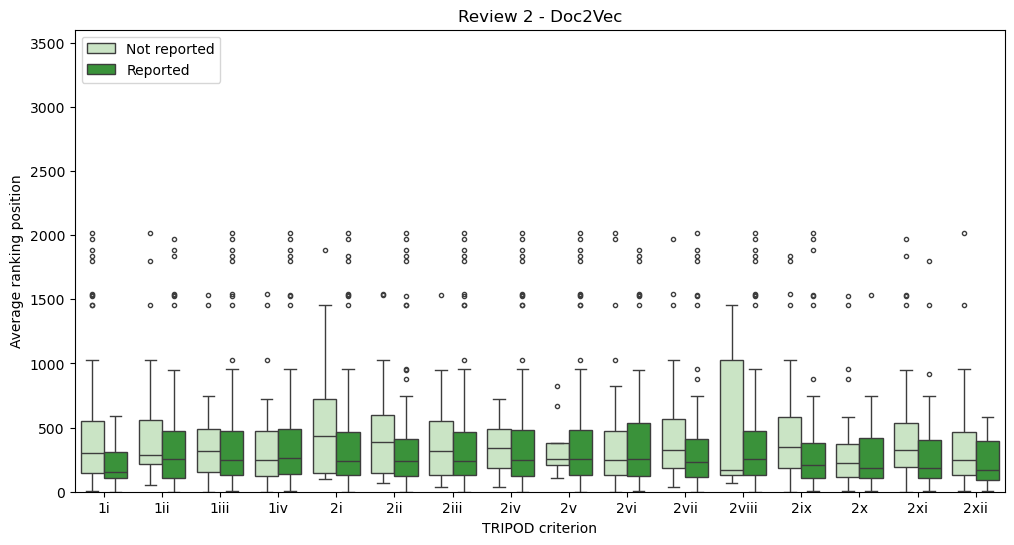

In [25]:
rankings = ['TF-IDF', 'sBERT', 'Doc2Vec']
main_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']     
light_colors = ['#c6dbef', '#fdd0a2', '#c7e9c0']   

for i, ranking in enumerate(rankings):
    color_main = main_colors[i]
    color_light = light_colors[i]
    
    for df_name in dfs:
        df_plot2 = review_dic_merged[df_name].copy()
        
        selected_columns = [ranking] + list(df_plot2.filter(regex='^(1|2)'))
        df_selected = df_plot2[selected_columns]
        
        df_melted = df_selected.melt(id_vars=ranking, var_name='item', value_name='value')
        df_melted[ranking] = pd.to_numeric(df_melted[ranking])
        
        fill_palette = {0: color_light, 1: color_main}
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            x="item", 
            y=ranking, 
            hue="value", 
            data=df_melted,
            palette=fill_palette,
            flierprops={"marker": "o", "markersize": 3}
        )
        
        if df_name == 'Review 1':
            plt.ylim(0, 1399)
        elif df_name == 'Review 2':
            plt.ylim(0, 3600)
        
        plt.ylabel("Average ranking position")
        plt.xlabel("TRIPOD criterion")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(loc='upper left', frameon=True,
                   handles=handles, labels=['Not reported', 'Reported'])
        plt.title(f'{df_name} - {ranking}')
        
        plt.show()


To check the content of the outliers

In [27]:
sorted_prog3 = review_dic_merged['Review 2'].sort_values(by='sBERT', ascending=False)
print('outlier 1: \n\n', sorted_prog3['abstract'][0])
print('\noutlier 2: \n\n', sorted_prog3['abstract'][1])

outlier 1: 

 OBJECTIVES: Among antiretroviral therapy (ART)-naive individuals, viral load levels tend to increase and CD4 cell counts decline over time. We sought to explore the rate of change and influence of other factors associated with these markers of HIV progression. DESIGN: An observational cohort collaboration study. METHODS: A total of 158 385 pairs of consecutive viral load and CD4 cell count simultaneously measured from 34 384 ART-naive individuals in the COHERE database were analysed. Annual changes and factors associated with these changes were estimated using generalized estimating equations. RESULTS: Viral load continued to rise at a mean [95% confidence interval (CI)] rate of 0.091 (0.086-0.096) log10 copies/ml per year. A faster rise in viral load was significantly associated with older age, such that for every 10 years older, it was a mean 0.022 log10 copies/ml per year greater. The mean (95% CI) CD4 cell count change was -78.0 (-80.1 to -76.0) cell/mul per year and 